Here are a few examples of using trained networks to transfer styles to images.

In [1]:
import torch
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.autograd import Variable
from torch.utils.serialization import load_lua
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
import pdb
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

GPU = True
DTYPE = torch.cuda.FloatTensor

In [46]:
centerCrop = transforms.CenterCrop((336,336))
toTens = transforms.ToTensor()
pilTrans = transforms.ToPILImage()

In [5]:
#redefine our model, so we can load trained weights into it. 
#This model should really be its own file, 
#so that we avoid duplication with train.ipynb

class ResidualBlock(nn.Module):
    def __init__(self, num):
        super(ResidualBlock, self).__init__()
        self.c1 = nn.Conv2d(num, num, kernel_size=3, stride=1, padding=1)
        self.c2 = nn.Conv2d(num, num, kernel_size=3, stride=1, padding=1)
        self.b1 = nn.BatchNorm2d(num)
        self.b2 = nn.BatchNorm2d(num)

    def forward(self, x):
        h = F.relu(self.b1(self.c1(x)))
        h = self.b2(self.c2(h))
        return h + x
    
    
class FastTransNet(nn.Module):
    def __init__(self):
        super(FastTransNet, self).__init__()
        self.ref_padding = torch.nn.ReflectionPad2d(40)
        self.cs1 = nn.Conv2d(3, 32, kernel_size=9, stride=1, padding=4) 
        self.cs2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) 
        self.cs3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) 
        
        self.b1s1 =nn.BatchNorm2d(32)
        self.b1s2 =nn.BatchNorm2d(64)
        self.b1s3 =nn.BatchNorm2d(128)
        
        self.rs1 =  ResidualBlock(128)
        self.rs2 =  ResidualBlock(128)
        self.rs3 =  ResidualBlock(128)
        self.rs4 =  ResidualBlock(128)
        self.rs5 =  ResidualBlock(128)
        
        self.ds1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.ds2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        
        self.b2s1 = nn.BatchNorm2d(64)
        self.b2s2 = nn.BatchNorm2d(32)
        self.d3 = nn.Conv2d(32, 3, kernel_size=9, stride=1, padding=4)

    def forward(self, h):
        h = self.ref_padding(h)
        h = F.relu(self.b1s1(self.cs1(h)))
        h = F.relu(self.b1s2(self.cs2(h)))
        h = F.relu(self.b1s3(self.cs3(h)))
        h = self.rs1(h)
        h = self.rs2(h);
        h = self.rs3(h);
        h = self.rs4(h);
        h = self.rs5(h);
        h = F.relu(self.b2s1(self.ds1(h)))
        h = F.relu(self.b2s2(self.ds2(h)))
        h = self.d3(h)
        return (F.tanh(h) + 1.0) / 2

In [12]:
#helper to actually transfer style
def transfer_style(model, img):
    #transform the img into a tensor, run it through the network, then transform it back into an image
    return pilTrans(model(toTens(img).unsqueeze(0)).squeeze().data)

The images we'll transfer style to.

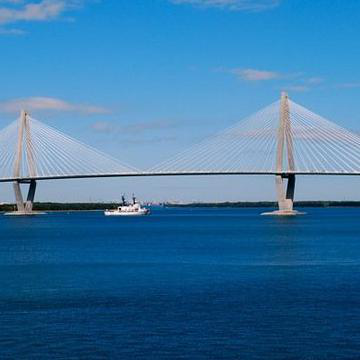

In [3]:
bridge = Image.open('data/bridge_crop.jpg'); bridge   #centerCrop(bridge)

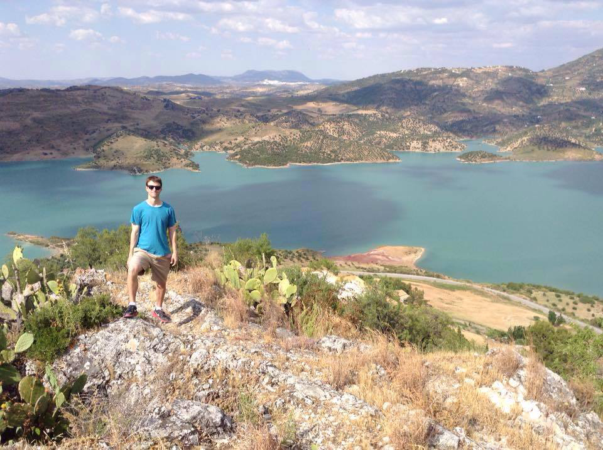

In [29]:
spain = Image.open('data/spain.jpg'); 
spain =  transforms.Scale(450)(spain)
spain

## The Peanuts

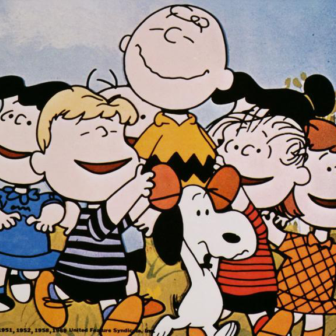

In [48]:
#this is the image used to train the style network
peanuts = Image.open('data/charlie_brown.jpg');
sc = transforms.Scale(336)
peanuts  = centerCrop(sc(peanuts)); peanuts

In [49]:
#create our model and load the trained weights into it
transNet = FastTransNet()
transNet.load_state_dict(torch.load('models/charlie_brownx10_tanh.pt'))

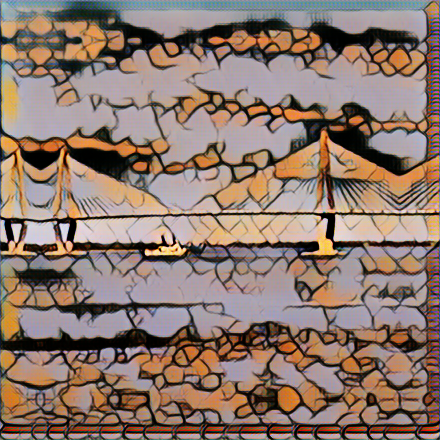

In [50]:
bridge_trans = transfer_style(transNet, bridge)
bridge_trans.save('output_img/bridge_peanuts.jpg')
bridge_trans

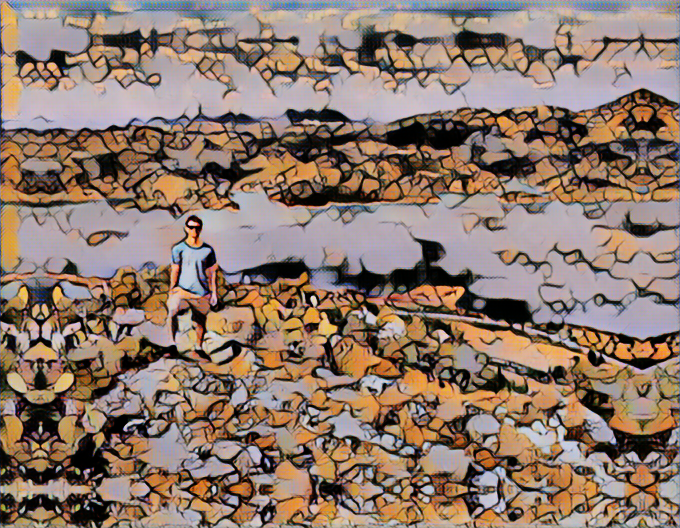

In [51]:
spain_trans = transfer_style(transNet, spain)
spain_trans.save('output_img/spain_peanuts.jpg')
spain_trans

## Jasper Johns Map

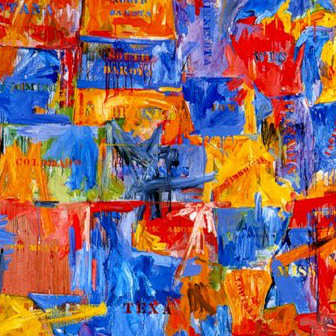

In [53]:
johns = Image.open('data/johns_2.jpg');
johns = centerCrop(johns); johns

In [54]:
transNet = FastTransNet()
transNet.load_state_dict(torch.load('models/johns_3.pt'))

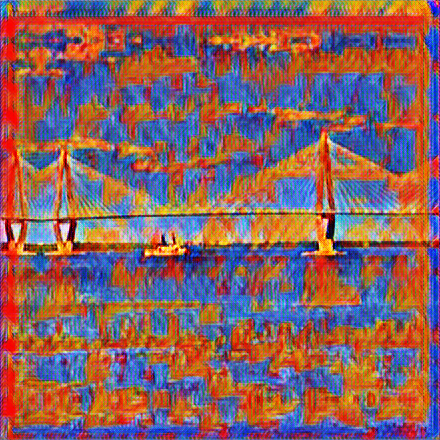

In [55]:
bridge_trans = transfer_style(transNet, bridge)
bridge_trans.save('output_img/bridge_map.jpg')
bridge_trans

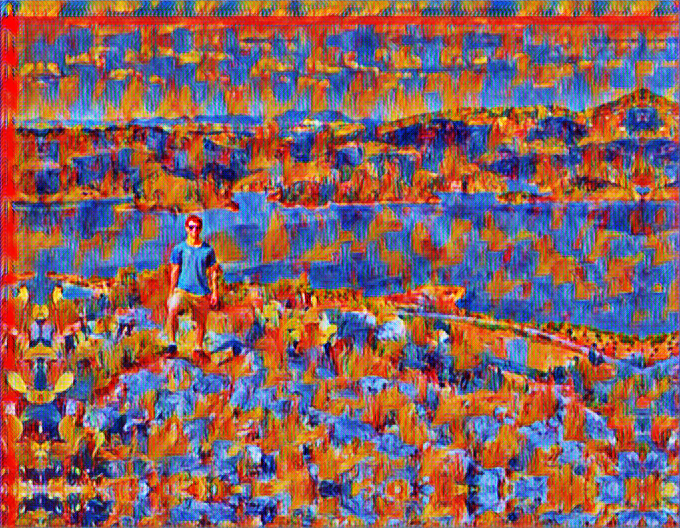

In [56]:
spain_trans = transfer_style(transNet, spain)
spain_trans.save('output_img/spain_map.jpg')
spain_trans

## Van Gogh Olive Trees

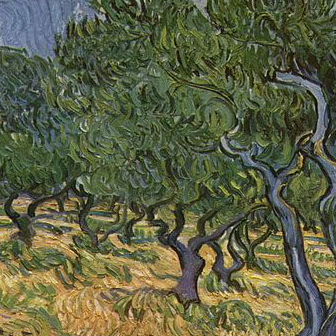

In [57]:
olives = Image.open('data/olives_2.jpg');
olives = centerCrop(olives); olives

In [58]:
transNet = FastTransNet()
transNet.load_state_dict(torch.load('models/olives_high_content_stylex100_tanh.pt'))

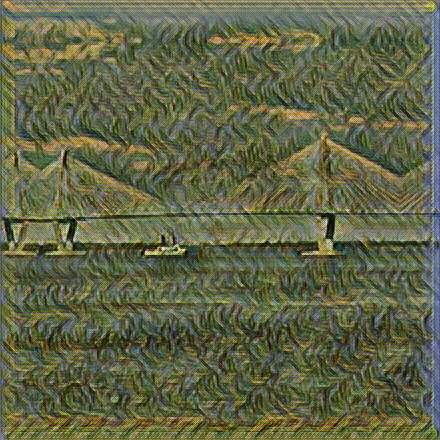

In [59]:
bridge_trans = transfer_style(transNet, bridge)
bridge_trans.save('output_img/bridge_olives.jpg')
bridge_trans

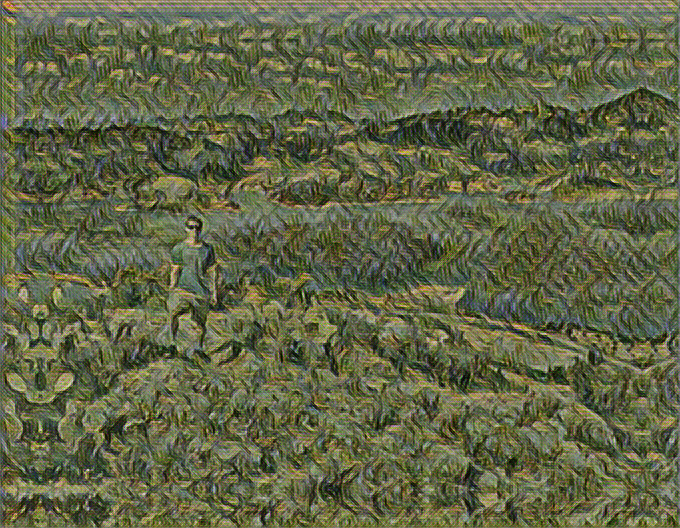

In [60]:
spain_trans = transfer_style(transNet, spain)
spain_trans.save('output_img/spain_olives.jpg')
spain_trans